In [1]:
import pandas as pd
import numpy as np
import pystan
from fbprophet import Prophet
import seaborn as sns
import matplotlib.pyplot as plt
# show plots in the notebook
%matplotlib inline
sns.set(font_scale=1, rc={"figure.figsize": (8, 4)})
pd.options.display.float_format = '{:.3f}'.format

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


In [ ]:
model_code = 'parameters {real y;} model {y ~ normal(0,1);}'
model = pystan.StanModel(model_code=model_code)  # this will take a minute
y = model.sampling(n_jobs=1).extract()['y']
y.mean()  # should be close to 0

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5944b02c79788fa0db5b3a93728ca2bf NOW.


In [ ]:
df = pd.read_csv('https://github.com/PinkWink/DataScience/blob/master/data/07.%20example_wp_peyton_manning.csv')
df['y'] = np.log(df['y'])
df.head()

In [ ]:
m = Prophet()
m.fit(df);

In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
m.plot(forecast);

In [ ]:
m.plot_components(forecast);

In [ ]:
# Forecasting website traffic
import pandas as pd
import numpy as np
from fbprophet import Prophet

data_file = "All Web Site Data Audience Overview.xlsx"
df = pd.read_excel(data_file)
df.head()

In [ ]:
df.dtypes

In [ ]:
df.set_index('Day Index').plot();

In [12]:
# Address outliers by changing them to NaNs
# df.loc[(df['Sessions'] > 5000), 'Sessions'] = np.nan
# df.set_index('Day Index').plot();

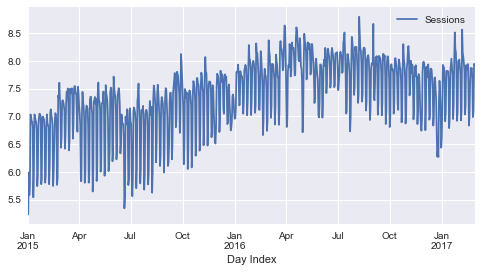

In [13]:
# Transform the Sessions to a log value (logging converts multiplicative relationships to additive relationships, and by the same token it converts exponential (compound growth) trends to linear trends)
df['Sessions'] = np.log(df['Sessions'])
df.set_index('Day Index').plot();

In [14]:
# Rename the columns to 'ds' and 'y' in order to comply with prophet API
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2015-01-01,5.231
1,2015-01-02,5.989
2,2015-01-03,5.583
3,2015-01-04,5.749
4,2015-01-05,7.034


In [3]:
# Create the first model (m1) and fit the data to our dataframe
m1 = Prophet()
m1.fit(df)

NameError: name 'df' is not defined

In [16]:
# In order to tell prophet how far to predict in the future, use make_future_dataframe
future1 = m1.make_future_dataframe(periods=365)

In [17]:
# Then make the forecast
forecast1 = m1.predict(future1)

In [18]:
# To see the last 5 predicted values:
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1150,2018-02-24,6.006,5.523,6.532
1151,2018-02-25,6.192,5.740,6.696
1152,2018-02-26,7.014,6.521,7.531
1153,2018-02-27,7.127,6.648,7.626
1154,2018-02-28,7.070,6.555,7.599


In [19]:
# To convert back to the numerical values representing sessions, use np.exp
np.exp(forecast1[['yhat', 'yhat_lower', 'yhat_upper']].tail())

,yhat,yhat_lower,yhat_upper
1150,405.912,250.348,686.588
1151,488.699,310.992,808.972
1152,1112.082,678.956,1865.116
1153,1245.038,771.484,2050.909
1154,1176.093,702.691,1996.973


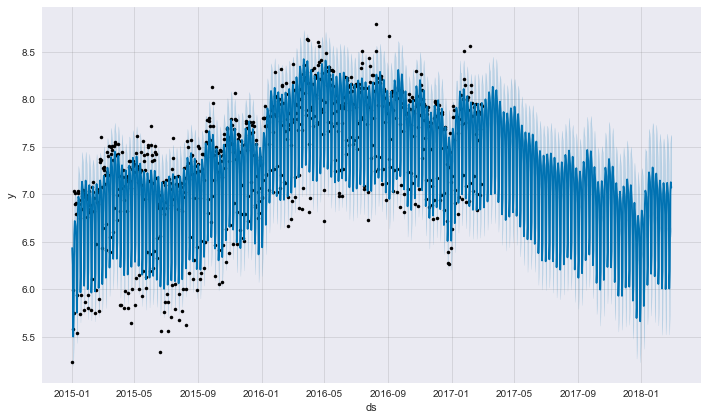

In [20]:
# Plot the forecast
m1.plot(forecast1);

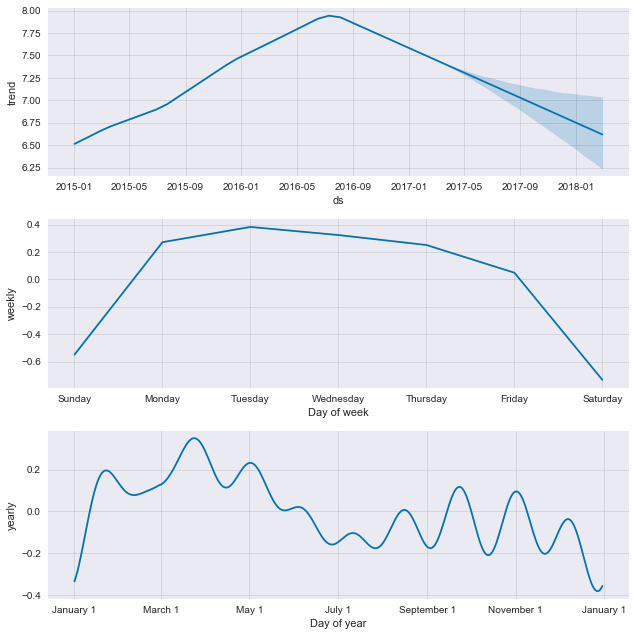

In [21]:
# The other useful feature is the ability to plot the various components:
m1.plot_components(forecast1);

In [22]:
# Account for holidays in the model. To capture the holidays, define a holiday dataframe with a datestamp and the description of the holiday:
holiday_df = pd.DataFrame({
  'holiday': 'fed_holiday',
  'ds': pd.to_datetime(['2017-01-01', '2017-01-02', '2017-01-16', '2017-02-20', '2017-04-17', '2017-05-29', '2017-07-04',
                        '2017-09-04', '2017-11-10', '2017-11-23', '2017-11-24', '2017-12-25',
                        '2018-01-01', '2018-01-15', '2018-02-19', '2018-04-16', '2018-05-28', '2018-07-04',
                        '2018-09-03', '2018-11-12', '2018-11-22', '2018-11-23', '2018-12-25'
                       ]),
  'lower_window': 0,
  'upper_window': 2,
})
holiday_df.head()

,ds,holiday,lower_window,upper_window
0,2017-01-01,fed_holiday,0,2
1,2017-01-02,fed_holiday,0,2
2,2017-01-16,fed_holiday,0,2
3,2017-02-20,fed_holiday,0,2
4,2017-04-17,fed_holiday,0,2


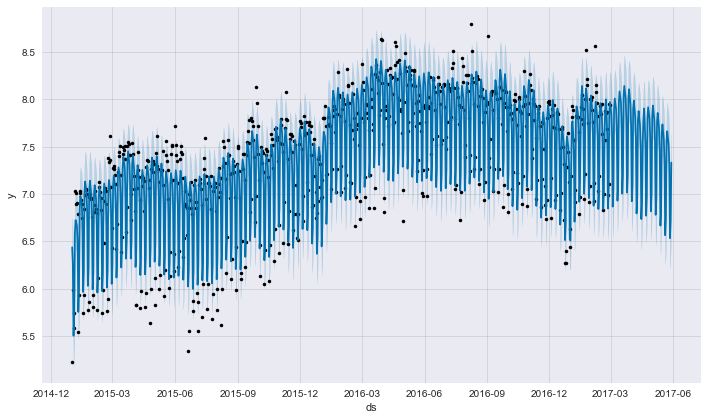

In [23]:
# To use the holidays in the model, pass it to the model via the 'holidays' keyword
m2 = Prophet(holidays=holiday_df).fit(df)
future2 = m2.make_future_dataframe(periods=90)
forecast2 = m2.predict(future2)
m2.plot(forecast2);

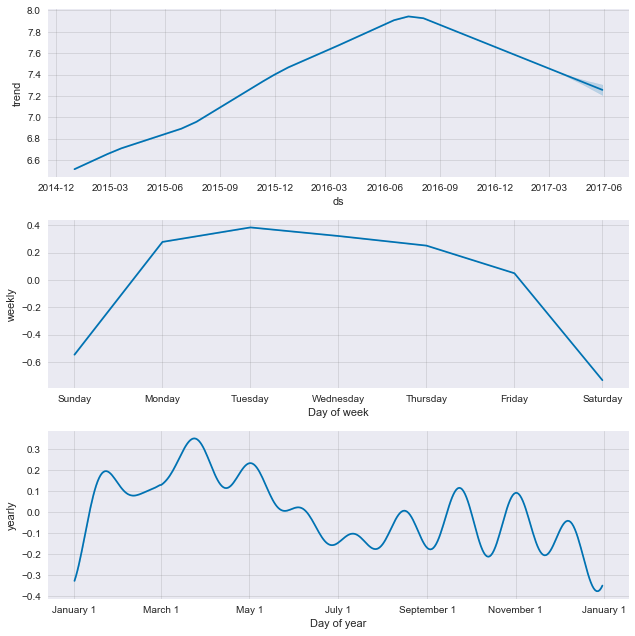

In [24]:
# Various components (w/ holidays added)
m1.plot_components(forecast2);

In [25]:
# Another model #3

# Create the model fit the df and adding in holidays along with mcmc_samples
m3 = Prophet(holidays=holiday_df, mcmc_samples=500).fit(df)
# Predict put 90 days into the future
future3 = m3.make_future_dataframe(periods=52, 'W')
# Create the forecast
forecast3 = m3.predict(future3)
# Transform the log values back via exp
forecast3["Sessions"] = np.exp(forecast3.yhat).round()
forecast3["Sessions_lower"] = np.exp(forecast3.yhat_lower).round()
forecast3["Sessions_upper"] = np.exp(forecast3.yhat_upper).round()

# Filter df forecast results to the next month
forecast3[(forecast3.ds > "3-31-2017") &
          (forecast3.ds < "5-1-2017")][["ds", "yhat", "Sessions_lower",
                                        "Sessions", "Sessions_upper"]]

,ds,yhat,Sessions_lower,Sessions,Sessions_upper
821,2017-04-01,6.975,772.000,1069.000,1488.000
822,2017-04-02,7.144,881.000,1266.000,1726.000
823,2017-04-03,7.950,2015.000,2835.000,3903.000
824,2017-04-04,8.036,2195.000,3090.000,4278.000
825,2017-04-05,7.956,2011.000,2853.000,4029.000
826,2017-04-06,7.868,1845.000,2611.000,3673.000
827,2017-04-07,7.647,1475.000,2094.000,2945.000
828,2017-04-08,6.849,675.000,943.000,1353.000
829,2017-04-09,7.022,808.000,1121.000,1589.000
830,2017-04-10,7.835,1766.000,2527.000,3602.000


In [ ]:
# Plot the components with uncertainty intervals by using the 'mcmc_samples' parameter
m1.plot_components(forecast2);